# Simple Introduction to Deep Equilibrium Nets
## Notebook 2: uncertainty and sampling states from the simulated path of the economy

Notebook by [Marlon Azinovic](https://sites.google.com/view/marlonazinovic/home?authuser=0), [Luca Gaegauf](https://www.phd-finance.uzh.ch/en/People/phd-candidates/luca-gaegauf.html), and [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home), August 2023.
### Purpose of the notebook and economic model  
The notebook is the second of three notebooks that should serve as a simple introduction to [Deep Equilibirium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), a deep learning based method introduced in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).  
To focus on the method, we are going to solve a simple optimal growth model with one representative agent, a simplified version of [Brock and Mirman (1972)](https://assoeconomiepolitique.org/wp-content/uploads/Brock-et-Mirman-1972.pdf).  
The previous notebook introduced the method in a setting with a single state variable ($\mathbf{X}_t = K_t$), without any uncertainty, and with sampling the states of the economy from an exogenously given interval $\mathcal{K}=[\underline{K}, \overline{K}]$.  
In this notebook we take the model a step further by introducing two new aspects.
1. We introduce **aggregate uncertainty** in form of an AR(1) process for the log of total factor productivity ($\log(z_t)$). The evaluation of the equilibrium hence involves the evaluation of an expectation operator requiring **numerical integration**. Furthermore, the state space will become two dimensional ($\mathbf{X}_t = [z_t, K_t]$).
2. The second new aspect we introduce is to sample the states, which we train the neural network on, from **simulated paths** of the economy. This is especially usefull when the state-space becomes high-dimensional. Since the state variables of economic models are often heavily correlated, training the neural network on a hyper-cubic domain is often exponentially wasteful (see [Maliar et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0165188910002186) for more information on this topic).


Similarly to the previous notebook the planner aims to maximize her time-separable life time utility subject to her budget constraint:
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t}E\left[ \ln\left(C_{t}\right) \right]\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where now 
\begin{align}
Y_t &= z_t K_{t} ^ \alpha \\
\log(z_t) &= \rho \log(z_{t - 1}) + \sigma \epsilon_t\\
\epsilon_t &\sim N(0, 1).
\end{align}
The difference to the previous notebook is that production now depends on a random variable, $z_t$, which (in logs) follows an AR(1) process with persistence $\rho$ and with a standard deviation of innovations given by $\sigma$.
The case, where $\rho = 1$ and $\sigma = 0$, corresponds to the certainty case solved in the previous notebook.

The above problem can again be formulated recursively, where the Bellman equation is given by
\begin{align}
V(z_t, K_t) &= \max_{K_{t+1}} \ln\left(C_{t}\right)+\beta E\left[V(z_{t+1}, K_{t+1})\right]\\
\text{subject to: }C_t &= Y_t + (1 - \delta) K_t - K_{t+1}
\end{align}
the **state** of the economy is now 2-dimensional and given by $\mathbf{X}_t = [z_t, K_t]$ as before the **policy** is 1-dimensional and dented with $f(\mathbf{X}_t) = K_{t+1}$.

Again we are interested in approximating the policy $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(\mathbf{X}_t) = \mathcal{N}([z_t, K_t]) \approx f(\mathbf{X}_t) = K_{t+1} $.  
Taking the first order condition with respect to $K_{t+1}$ and applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem) (we follow the same steps as in Notebook 1), we obtain
\begin{align}
0 &= -\frac{1}{C_t} + \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]
\end{align}
where 
\begin{align}
Y_t &= z_t K_{t} ^ \alpha\\
r_{t} &= \alpha z_{t} K_{t}^{\alpha - 1}\\
C_t &= Y_t + (1 - \delta) K_t - K_{t+1}\\
\log(z_{t+1}) &= \rho \log(z_{t}) + \sigma \epsilon_{t+1}.
\end{align}  

The difference to the equation derived in the precvious notebook is the expectation operator on the right hand side, with the terms inside the expecation potentially varying with the realiztion of $z_{t+1}$.

Our goal is again to find a policy function $f(\cdot)$, such that this equation is fullfilled for $K_{t+1}= f(\mathbf{X}_t)$ and $K_{t+2}= f(\mathbf{X}_{t+1})$.  
In order to be able to interpret the remaining errors in the equilibrium condition, we again reformulate it such that deviations from 0 can be interpreted as relative consumption errors:
\begin{align}
0 &= -\frac{1}{C_t} + \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]\\
\Leftrightarrow C_t &= \frac{1}{\beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} \\
\Leftrightarrow 0 &= \frac{1}{C_t \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}

We will encode this equation as the **loss function** to train the neural network. I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fullfills the equation above for given states $\mathbf{X}$.  
**Three remarks are in order:**
1. As before we can approximate the savings rate $s_t$, such that $K_{t+1} = (1 - \delta) K_t + Y_t s_t =(1 - \delta) K_t +  Y_t \mathcal{N}(K_t)$. Since $Y_t$ is completely determined given the state $\mathbf{X}_t$, which now also includes productivity $z_t$, this formulation again encodes the policy $K_{t+1}$, and we can again use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) to ensure that $s_t\in(0, 1)$ and hence $K_{t+1}\geq 0$ and $C_t\geq 0$. 
2. In contrast to the previous notebook, our equilibrium condition now requires us to evaluate an expectation operator. There are many ways to do this, and which is optimal depends on the problem at hand. In the given problem, the shocks $\epsilon_{t+1}$ are normally distributed and hence we can conveniently use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature), a form of [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature), which is designed to evaluate integrals of the form
\begin{align}
\int_{-\infty}^{+\infty}h(x)e^{-x^2}dx
\end{align}
by replacing the integral with a weighted sum over the function evaluated at $n$ points
\begin{align}
\int_{-\infty}^{+\infty}h(x)e^{-x^2}dx \approx \sum_{i=1}^{n}w_i h(x_i).
\end{align}
The $n$ integration nodes $\{x_i\}_{i = 1}^{n}$ and corresponding weights $\{w_i\}_{i = 1}^{n}$ are chosen from a (complicated) formula and the approximation is exact if $h$ is a polynomial of degree $2n - 1$ or lower. In our case, we do not know that the term inside the expectation is polynomial but it will be smooth enough for us to obtain a good approximation. In case we would solve models with kinks, for example, this assumption is violated and the accuracy of the numerical integration should be assessed. Alternative integration methods include, [(Quasi) Monte Carlo](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method), [Monomial rules](https://en.wikipedia.org/wiki/Numerical_integration), and many more (see the great book [Judd (1998)](https://numericalmethodsineconomics.com/)).  
Alternatively one could discretize the AR(1) process into a Markov Chain and then use plain summation with the transition probabilities, as in [Tauchen (1986)](https://www.sciencedirect.com/science/article/pii/0165176586901680) and [Rouwenhorst (1995)](https://chooser.crossref.org/?doi=10.2307%2Fj.ctv14163jx.16).  
One final remark is that the weights and nodes returned by functions that implement [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) are designed to integrate over $e^{-x^2}$ and hence the weights add up to $\sqrt{\pi}$. Since we want to integrate of the density $\frac{1}{\sqrt{\pi}}e^{-\left(\frac{x}{\sqrt{2}}\right)^2}$, we need to divide the weights by $\sqrt{\pi}$ and multiply the nodes with $\sqrt{2}$.

3. Again we want the equilibrium condition to hold for all possible states $\mathbf{X}_t$, but in practice we need to focus on a finite space. As in the last notebook, we startout in the simplest possible way and sample the state from an exogenously chosen rectangle $\mathcal{X}=[\underline{z}, \overline{z}] \times [\underline{K}, \overline{K}]$.
Since capital and the tfp shock are correlated this will be wasteful. Therefore, in a second step, we will show how we can **solve the model exlusively where it matters** by sampling the states to train the neural network from simulated paths of the economy. 

In [1]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

print("Version of tensorflow is {}".format(tf.__version__))

2024-06-26 11:55:37.485731: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 11:55:38.153863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:55:39.089899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:55:39.091192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 11:55:47.876924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Version of tensorflow is 2.12.0


### Evaluating the expectation operator
In this section we define the integration nodes and weights we will use to evaluate the expectation operator.  
We choose ```n_int``` integration points, denote the integration nodes by ```x_int_norm```, and the weights by ```w_int``` and obtain them using [```np.polynomial.hermite.hermgauss```](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.hermite.hermgauss.html).  
The actual integration nodes we use later will be multiplied with the standard deviation of the innovations.

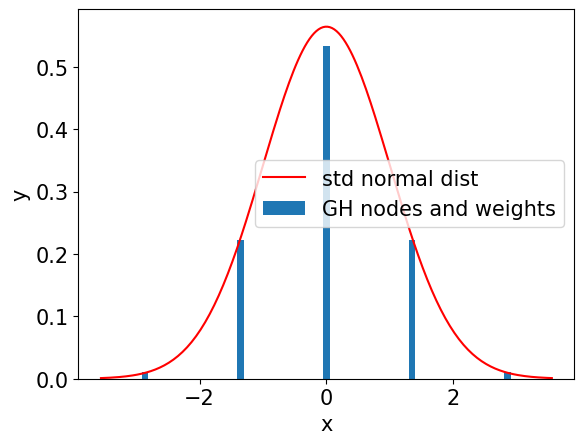

sum(w_int) =  1.0000001


In [3]:
n_int = 5 # integration nodes
x_int_norm, w_int = np.polynomial.hermite.hermgauss(n_int) # obtain standard GH nodes and weights
w_int = w_int / np.sqrt(np.pi) # divide the weights by sqrt(pi)
x_int_norm = x_int_norm * np.sqrt(2) # multiply weights with 2**0.5

#convert to tensorflow
x_int_norm = tf.constant(x_int_norm, dtype = tf.float32)
w_int = tf.constant(w_int, dtype = tf.float32)

# for plotting the normal distribution
x_plot_norm = np.linspace(np.min(x_int_norm) - 0.7, np.max(x_int_norm) + 0.7, 200)
y_plot_norm = np.exp(- 0.5 * x_plot_norm ** 2) / np.sqrt(np.pi)

plt.bar(x_int_norm, w_int, width = 0.1, label = "GH nodes and weights")
plt.plot(x_plot_norm, y_plot_norm, color = "r", label = "std normal dist")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# we should make sure the weights some to 1
print("sum(w_int) = ", np.sum(w_int))

### Implementing the loss function

We define the economic parameters, which are constant throughout and will be globals in this notebook.

In [4]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 0.1 # depreciation of capital
sigma_tfp = 0.04 # std. dev. for tfp process innvoations
rho_tfp = 0.9 # persistence of tfp process
x_int = x_int_norm * sigma_tfp # adjust the integration nodes

Since this model can be solved analytically for the full depreciation case, we implement the analytical solution (so that we can later check the solution found by the neural network).

In [5]:
def k_compute_infty(alpha, beta):
    """ Return the stationary point (or steady state) for full depreciation """
    return (1 / (beta * alpha))**(1/(alpha - 1))

k_infty = k_compute_infty(alpha, beta)
print("Stationary point is {:5f}".format(k_infty))


def Kplus_compute_analytic(K, alpha, beta):
    """ Return the optimal capital stock in the next period  for full depreciation """
    return alpha * beta * K**alpha


def c_compute(K, Knext, alpha, beta):
    """ Return the optimal consumption policy  for full depreciation """
    return Knext**alpha - Knext

Stationary point is 0.199482


#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the savings rate $s_t$, such that $K_{t+1} = Y_t s_t \approx Y_t \mathcal{N}\left(K_t \right)$.  
The neural network input is hence a now 2-dimensional state $\mathbf{X}_t = [z_t, K_t]$ and the output is the 1-dimesnional savings rate $s_t$.


##### Hyper parameters

* Hyper parameter defines the architecture of the deep neural net. 

* Note that the purpose of this notebook is in the demonstration of the deep neural net. Detail analyses of the choice of hyper parameters are omitted and we use a densely connected feed forward neural network with two hidden layers as in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575). Since we are approximating the savings rate, we want our architecture to ensure that $s_t \in (0, 1)$. We can do this by using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) in the output layer. This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al. (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).  We assume the following structure of layers and activation functions: 
    * Layer 1: the input layer, 2 neurons corresponding to the tfp value $z_t$ and the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neuron corresponding to the savings rate $s_t$, such that $K_{t+1}=(1 - \delta) K_t + Y_t s_t$. We use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6), ensuring that $s_t \in (0, 1)$.

In [6]:
# Layer setting
num_input = 2
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [2, 50, 50, 1]


##### We define the neural network
We use [Keras](https://www.tensorflow.org/guide/keras) to define the neural network

In [7]:
# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation='sigmoid')
])

In [8]:
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________
None


##### The batch dimension
Since neural networks are highly parallelizable, we typically do not want to evaluate the neural network for only a single state $\mathbf{X} \in \mathbb{R}^2$, but for a matrix of $N_{data}$ different states $X \in \mathbb{R}^{N_{data}\times 2}$. The output of the neural network is then a vector $\mathbf{s}\in \mathbb{R}^{N_{data}\times 1}$.  
The convention in deep learning is to have the different data samples on the 0-axis.

In [9]:
# test it
X_test = np.array([[1., 1.], [0.5, 2.]])

print("X_test = ", X_test)
print("nn prediction = ", nn(X_test))

X_test =  [[1.  1. ]
 [0.5 2. ]]
nn prediction =  tf.Tensor(
[[0.5551413]
 [0.5653489]], shape=(2, 1), dtype=float32)


#### Implementing the cost function
As outlined above, we want to implement a cost-function which takes a vector of states $\mathbf{X}\in \mathbb{R}^{N_{data}\times 2}$ and a neural network $\mathcal{N}(\cdot)$, and then returns a vector of errors in the equilibrium conditions implied by the policy, which is encoded by the neural network.  
As explained above, the equilibrium condition is given by
\begin{align}
0 &= \frac{1}{C_t \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}
We use the [tf.function decorator](https://www.tensorflow.org/guide/function), which speeds up the evaluation of the cost function.

To compute the expecation operator we will iterate over the ```n_int``` states in the period $t+1$.
Hence we start out with programming a helper function that takes states $X_{t+1}$ and the neural network as input and returns the term inside the expectation $\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)$. 

In [10]:
@tf.function
def get_singleinside(X_tplus1, nn):
    n_data = X_tplus1.shape[0] # number of states is on the axis 0
    dim_state = X_tplus1.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state 
    Z_tplus1 = X_tplus1[:, 0 : 1]
    K_tplus1 = X_tplus1[:, 1 : 2]
    
    # compute output
    Y_tplus1 = Z_tplus1 * K_tplus1 ** alpha
    
    # compute the return
    r_tplus1 = alpha * Z_tplus1 * K_tplus1 ** (alpha - 1.)
    
    # use the neural network to predict the savings rate
    s_tplus1 = nn(X_tplus1)
    
    # Compute consumpption
    C_tplus1 = Y_tplus1 - Y_tplus1 * s_tplus1
    
    # compute term inside the expectation
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)
    
    return ret

In [11]:
# let's try
X_tplus1 = tf.constant([[1., 1.], [2., 2.], [2., 1.3]])

print("ret = ", get_singleinside(X_tplus1, nn))

ret =  tf.Tensor(
[[2.8323603]
 [1.3569474]
 [1.7375554]], shape=(3, 1), dtype=float32)


Now we are ready to compute the cost function.

In [12]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X[:, 0 : 1]
    K_t = X[:, 1 : 2]
    
    # compute output today
    Y_t = Z_t * K_t ** alpha
    
    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)
    
    # use the neural network to predict the savings rate
    s_t = nn(X)
    
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t
    
    # now we have to compute the expectation
    expectation = tf.zeros((n_data, dim_state))
    
    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]
        
        # innovation to the AR(1)
        innovation_i = x_int[i]
        
        # construct exogenous shock at t+1
        Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + innovation_i)
        
        # construct state at t+1
        X_tplus1 = tf.concat([Z_tplus1, K_tplus1], axis = 1)
        
        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, nn)
        
        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error
    
    # Define the relative Euler error
    errREE = 1. - 1. / (C_t * beta * expectation)
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = tf.reduce_mean(errREE ** 2)
    
    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost, errREE, C_t, K_tplus1, r_t, LHS, RHS

In [13]:
# let's try
X = tf.constant([[0.5, 1.], [0.9, 2.], [1.1, 3.]])

print("cost = ", compute_cost(X, nn)[0])

cost =  tf.Tensor(0.0014588089, shape=(), dtype=float32)


#### Gradients
Now we define a function that, for given data X, computes the gradient of the loss w.r.t. the neural network parameters.  
This gradient will be used to update the neural network parameters into the direction which decreases the loss function.

In [14]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [15]:
X = tf.constant([[1., 0.8], [2., 1.3], [0.5, 3.]])

loss, grads = grad(X, nn)

print("loss = ", loss)
print("grads = ", grads)

loss =  tf.Tensor(0.005986365, shape=(), dtype=float32)
grads =  [<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.00975571,  0.00994053, -0.00280656,  0.01311428,  0.00049922,
         0.        , -0.00637443, -0.00518749,  0.        ,  0.        ,
         0.        ,  0.00757676,  0.        , -0.00482827, -0.00342832,
         0.        ,  0.0089012 ,  0.        ,  0.        ,  0.        ,
         0.00054056,  0.        , -0.00362751,  0.        ,  0.        ,
         0.        ,  0.        , -0.00027905, -0.01093042, -0.00020901,
         0.00223406,  0.        ,  0.00034251, -0.00393802, -0.00408587,
         0.        ,  0.        , -0.00976669,  0.        ,  0.        ,
         0.        , -0.00567646,  0.        , -0.00771627,  0.00739488,
         0.00551277,  0.        , -0.00472067,  0.00484084,  0.00036352],
       [-0.00905656,  0.0066473 , -0.00529593,  0.00891737,  0.00968563,
         0.        ,  0.00230073, -0.00775871,  0.        ,  0.        ,
        

#### Optimizer
We now define an optimizer, essentially an improved version of SGD

In [16]:
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Sampling data exogenously
we make a function to generate training data.
Here we just sample exogenously from an interval.

In [17]:
def get_training_data(z_lb, z_ub, k_lb, k_ub, n_data):
    
    Z = tf.random.uniform(
        shape = [n_data, 1],
        minval=z_lb,
        maxval=z_ub,
        dtype=tf.dtypes.float32)
    
    
    K = tf.random.uniform(
        shape = [n_data, 1],
        minval=k_lb,
        maxval=k_ub,
        dtype=tf.dtypes.float32)
    
    X = tf.concat([Z, K], axis = 1)
    return X

## Training
We iterataively generate training data and update the neural network

#=================================================================
episode = 0, loss [log10] = -2.7081139087677


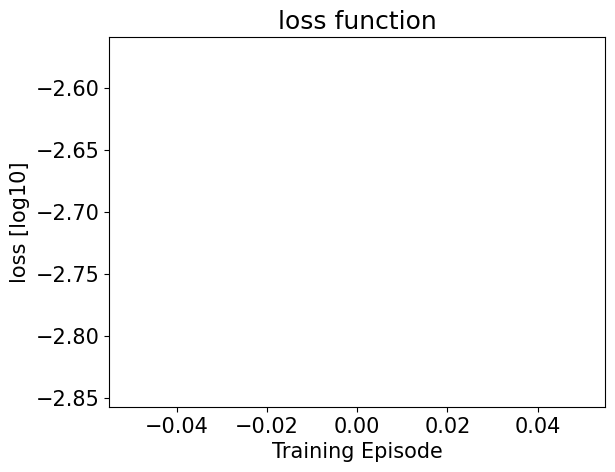

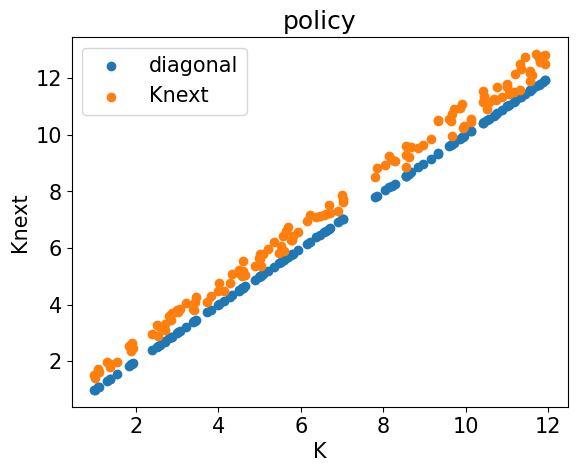

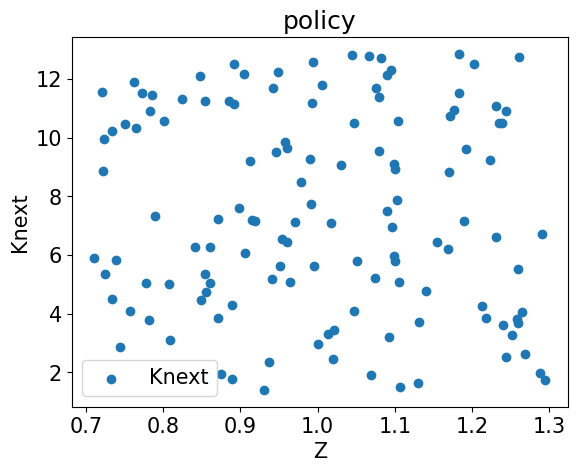

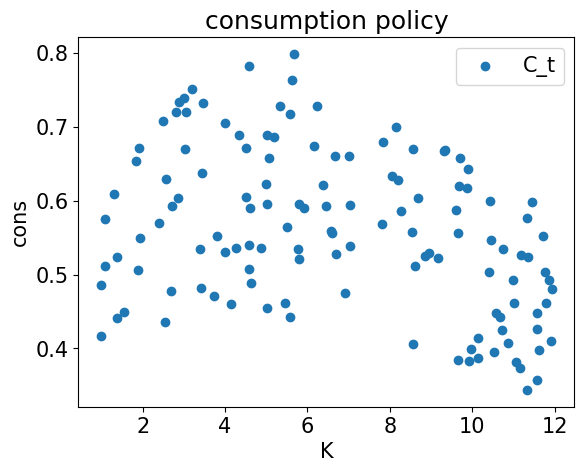

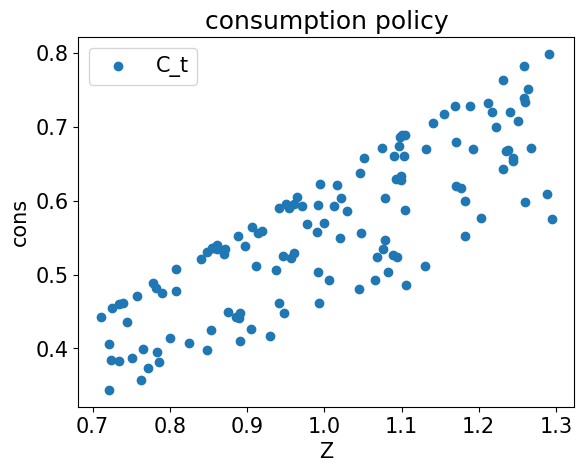

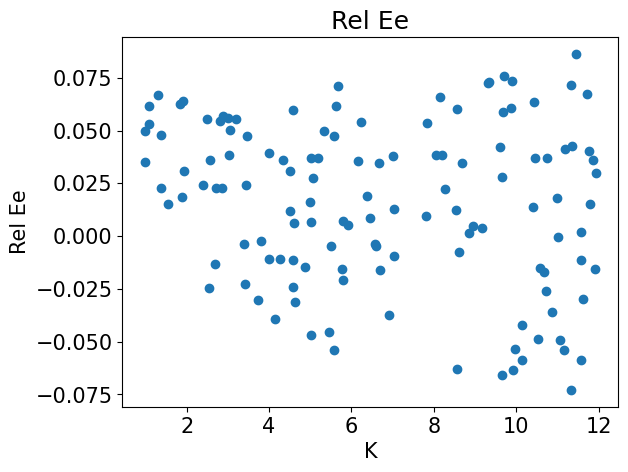

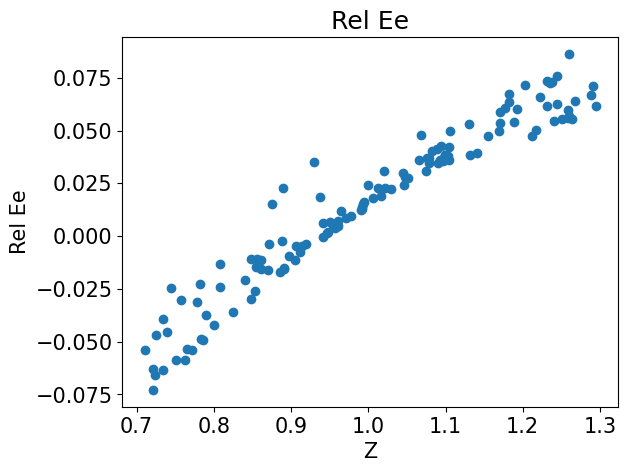

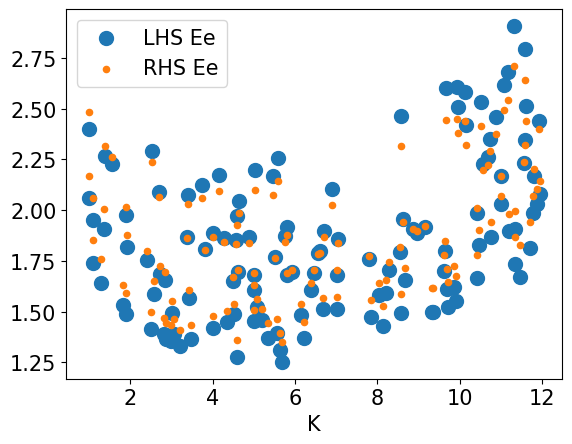

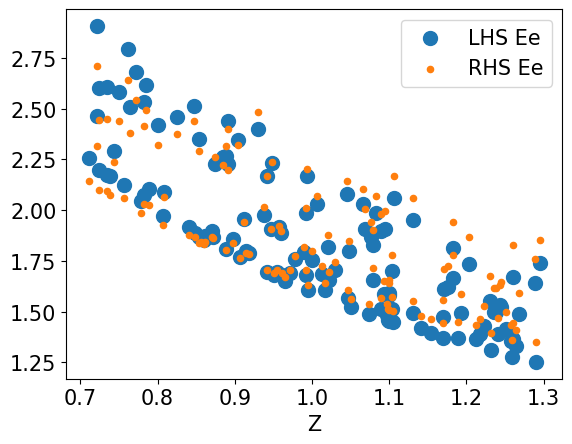

#=================================================================
episode = 1000, loss [log10] = -4.883571147918701
#=================================================================
episode = 2000, loss [log10] = -5.032479286193848
#=================================================================
episode = 3000, loss [log10] = -5.230673313140869
#=================================================================
episode = 4000, loss [log10] = -5.177770614624023


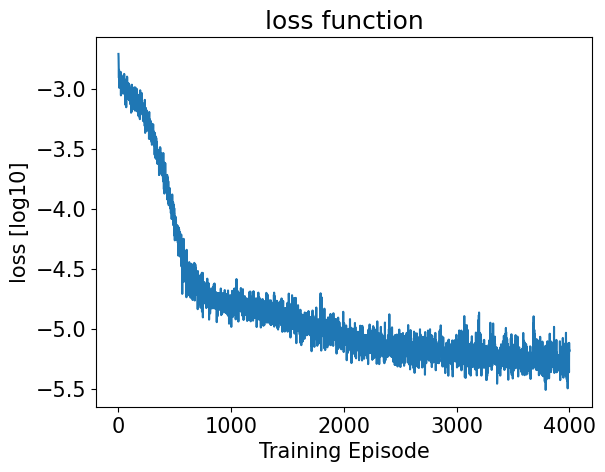

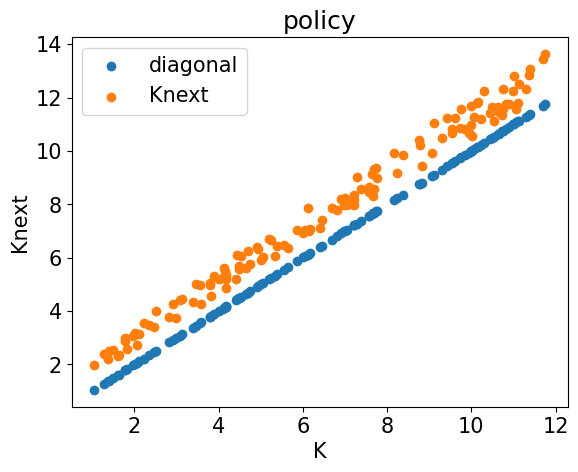

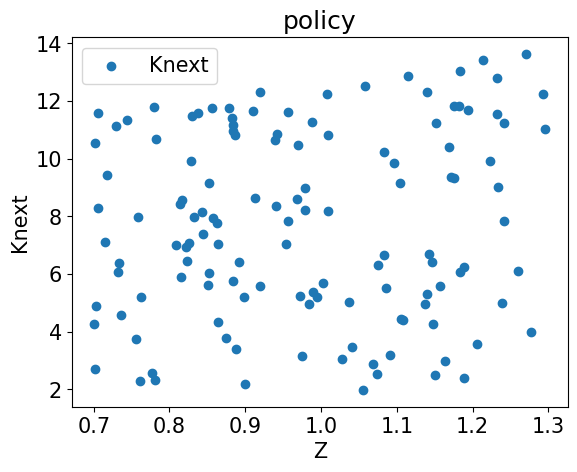

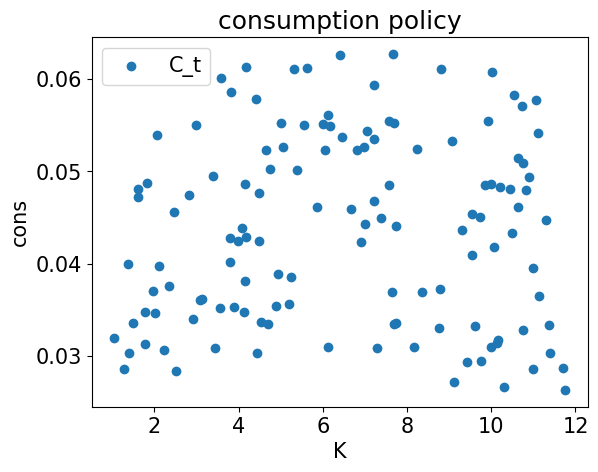

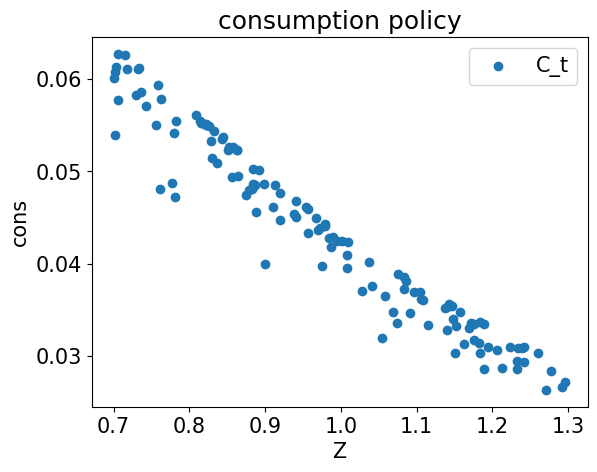

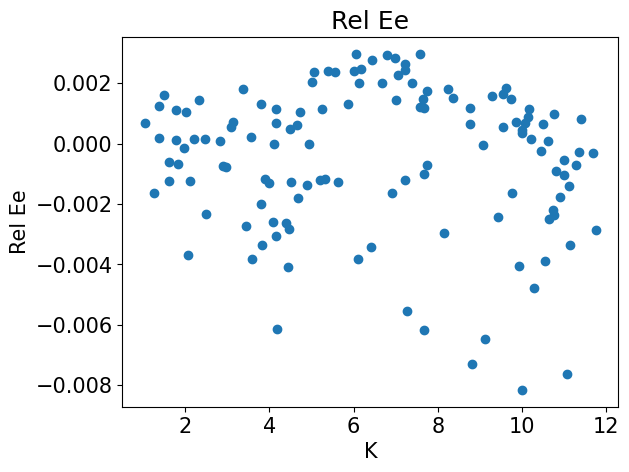

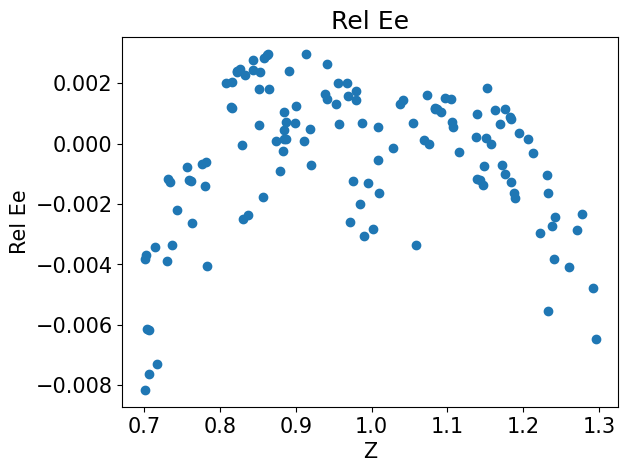

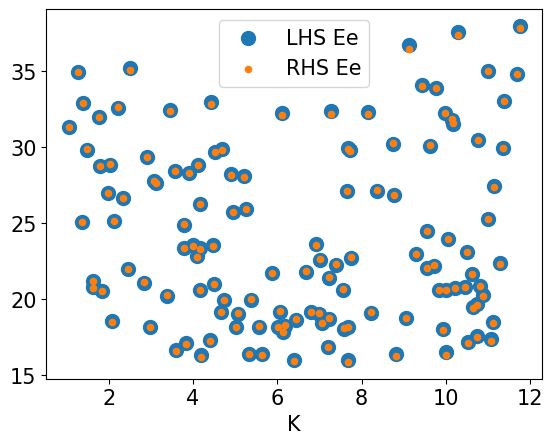

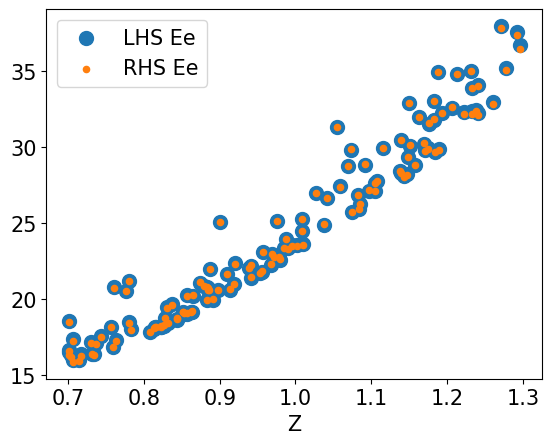

#=================================================================
episode = 5000, loss [log10] = -5.337478160858154
#=================================================================
episode = 6000, loss [log10] = -5.327043533325195
#=================================================================
episode = 7000, loss [log10] = -5.460773468017578
#=================================================================
episode = 8000, loss [log10] = -5.47992467880249


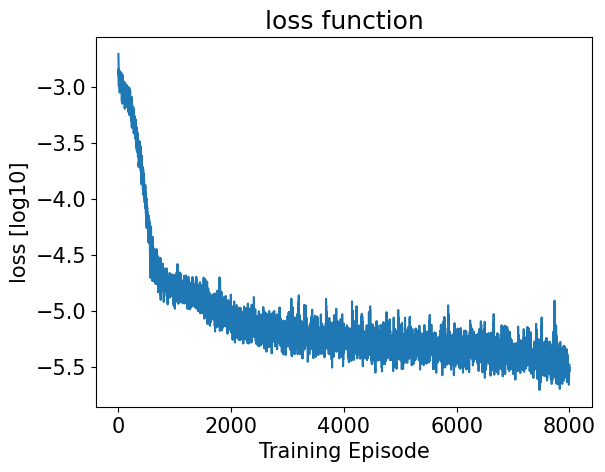

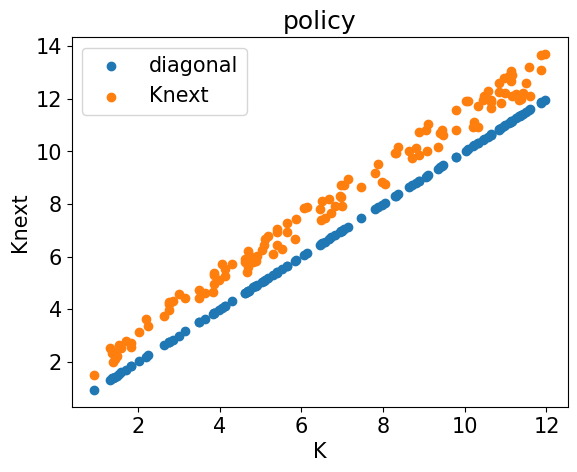

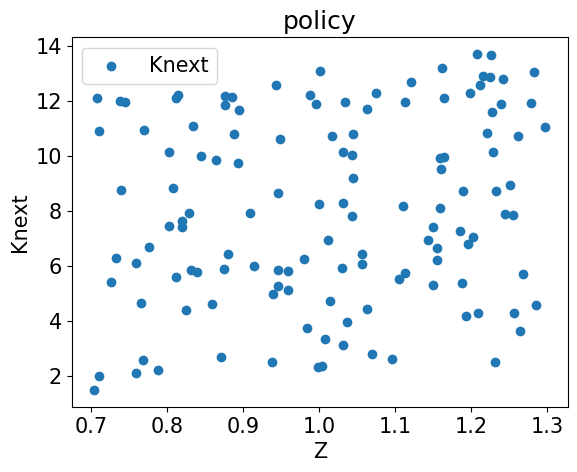

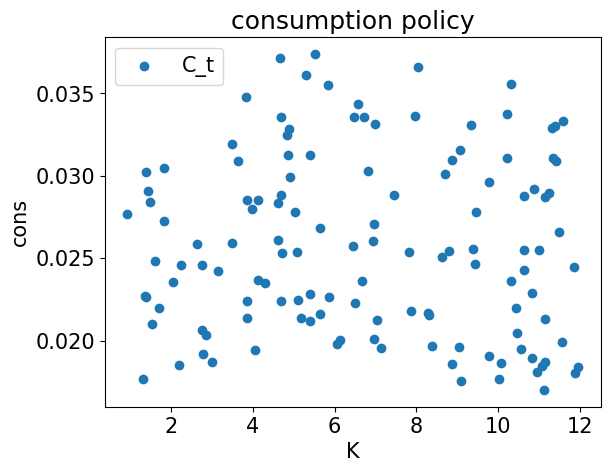

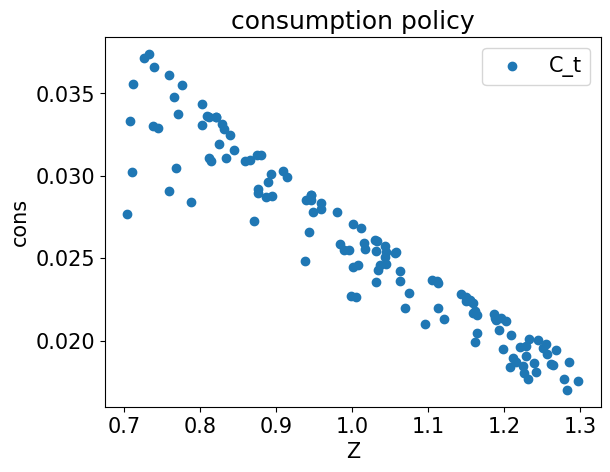

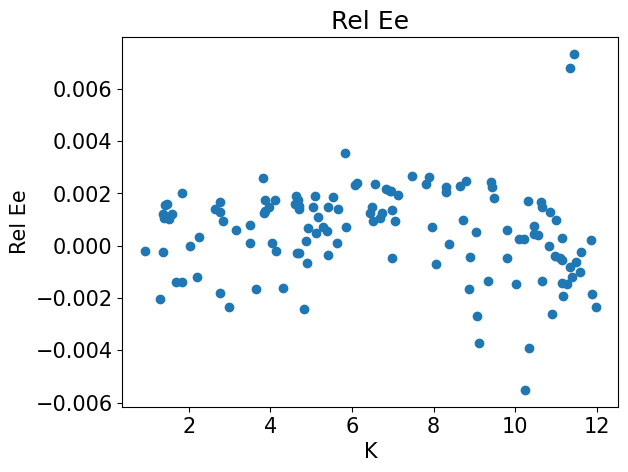

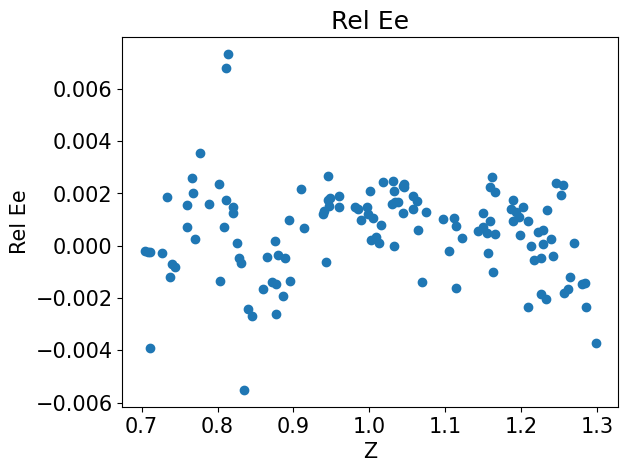

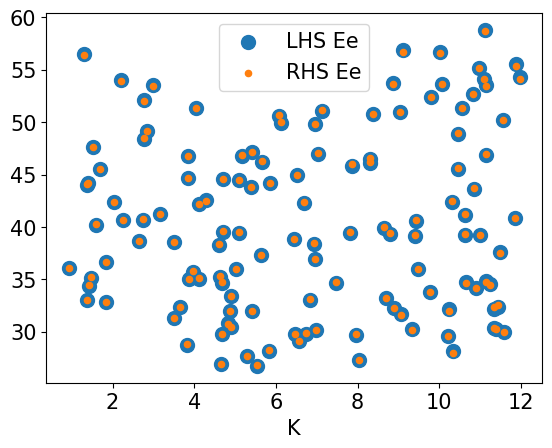

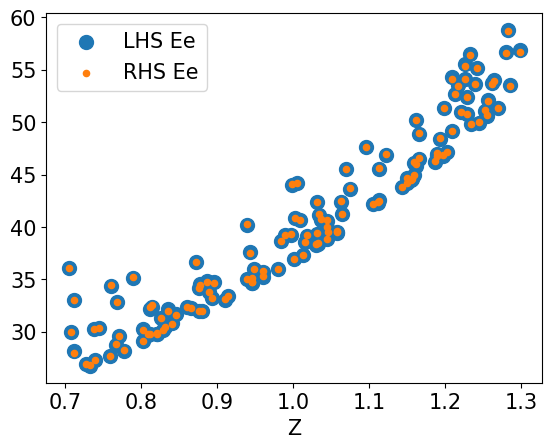

#=================================================================
episode = 9000, loss [log10] = -5.585878849029541
#=================================================================
episode = 10000, loss [log10] = -5.537192344665527
#=================================================================
episode = 11000, loss [log10] = -5.76545524597168
#=================================================================
episode = 12000, loss [log10] = -5.799617767333984


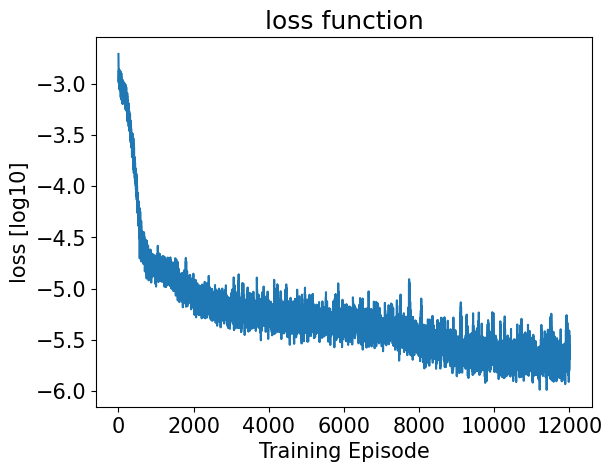

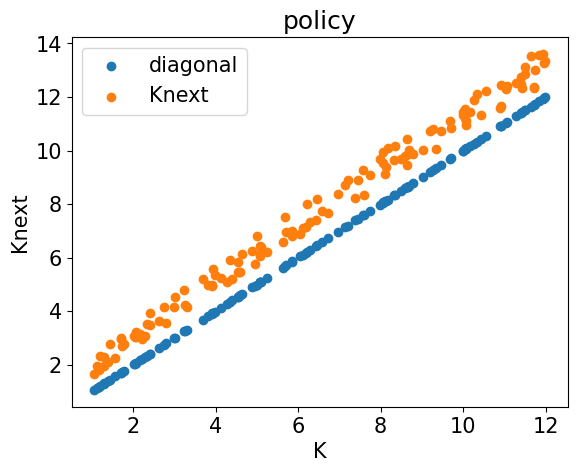

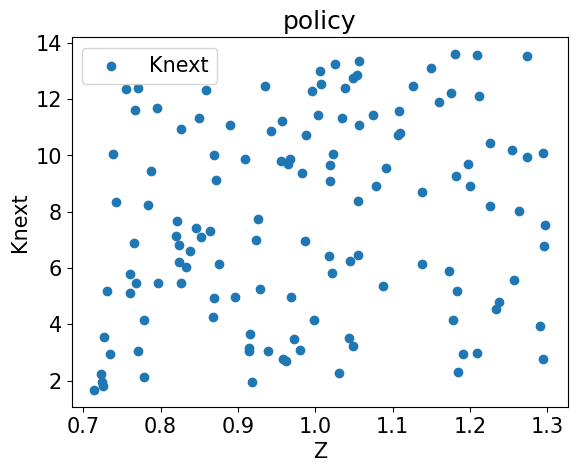

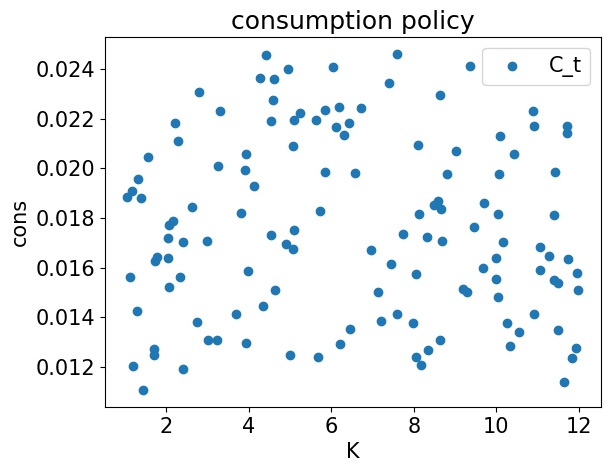

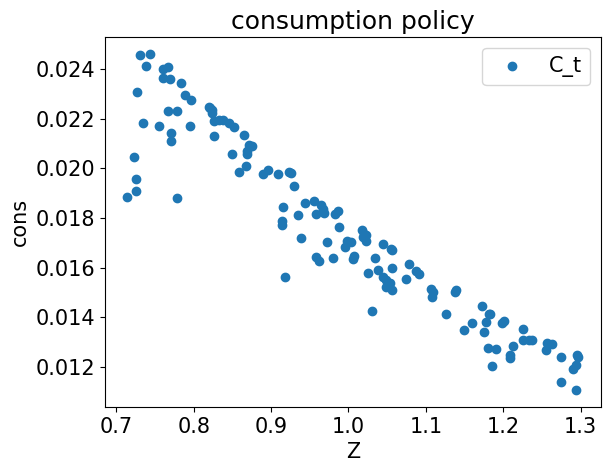

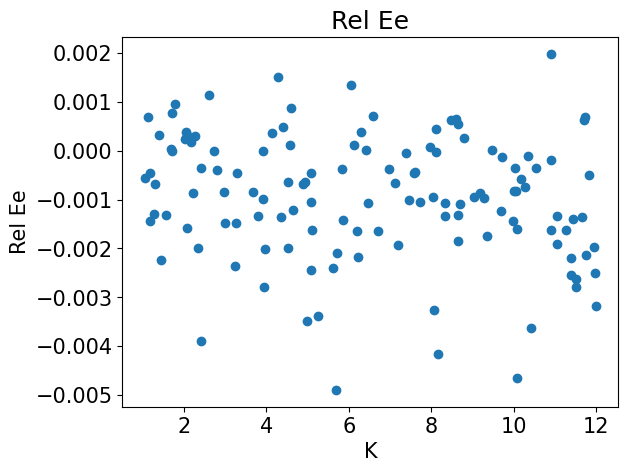

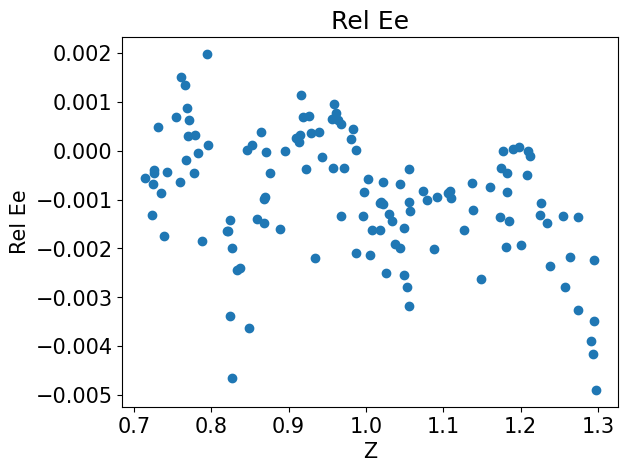

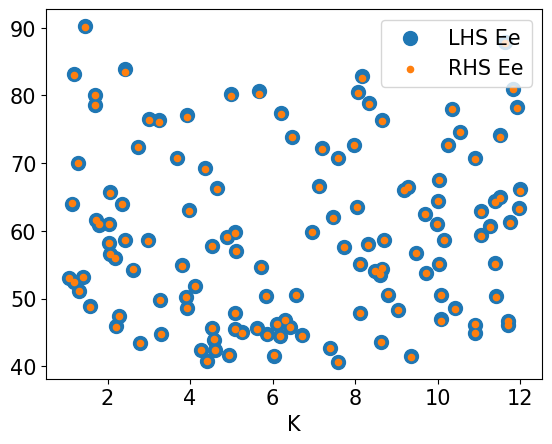

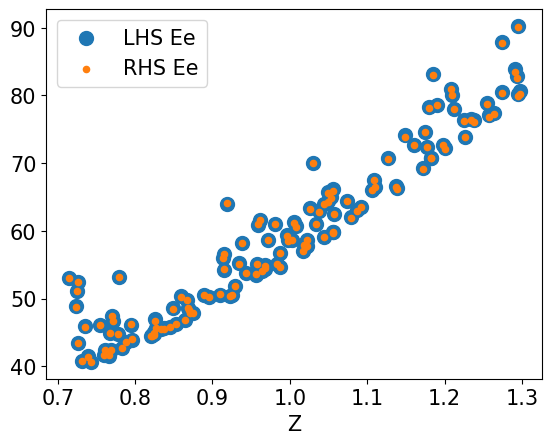

#=================================================================
episode = 13000, loss [log10] = -5.889766216278076
#=================================================================
episode = 14000, loss [log10] = -5.591099739074707
#=================================================================
episode = 15000, loss [log10] = -5.8313493728637695
#=================================================================
episode = 16000, loss [log10] = -5.930914402008057


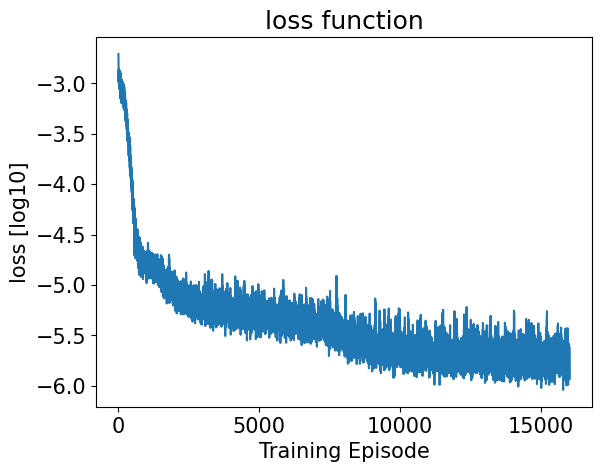

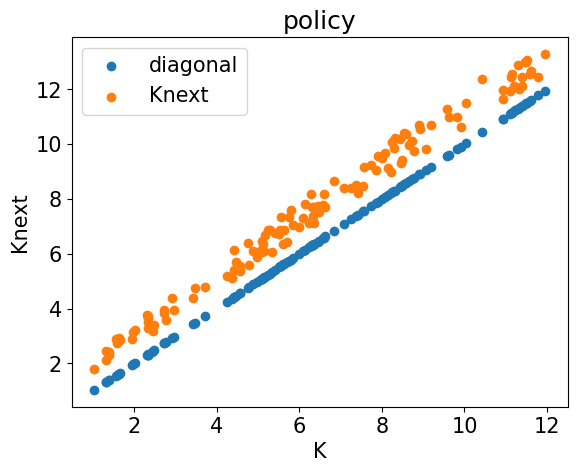

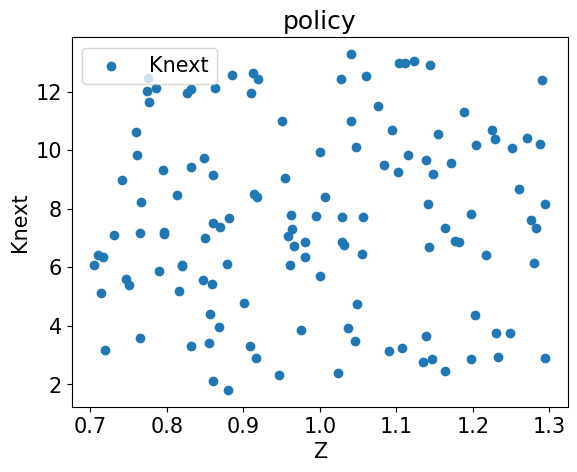

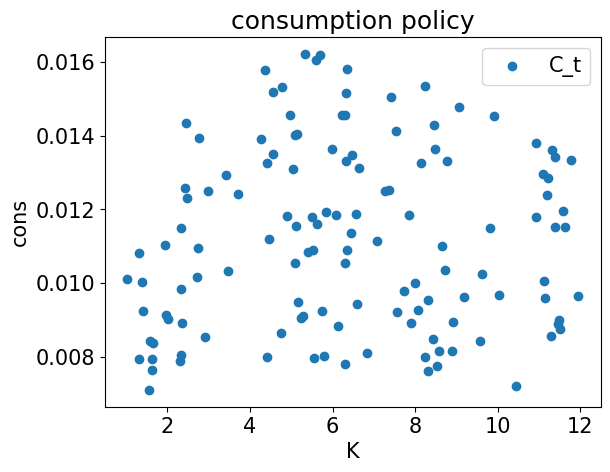

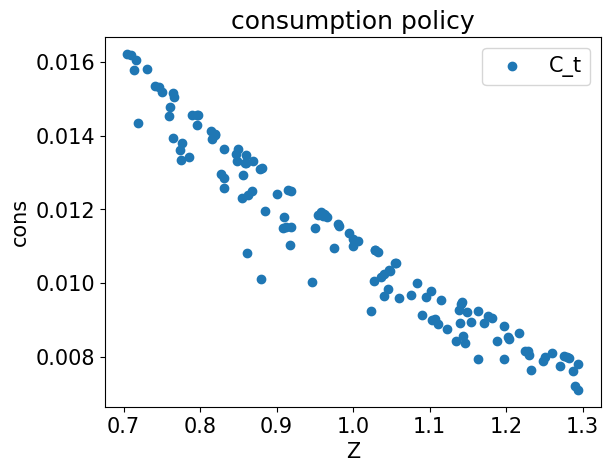

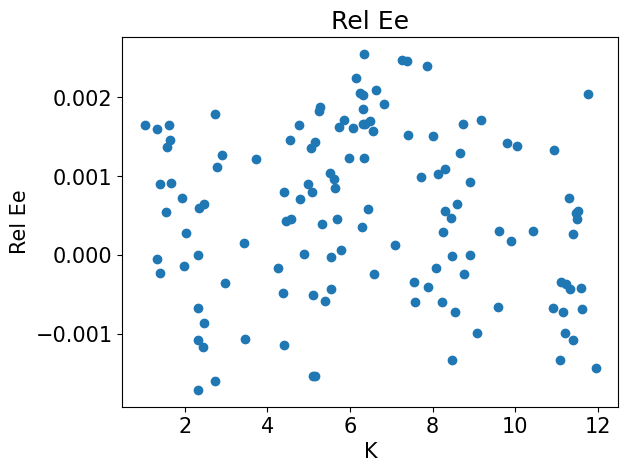

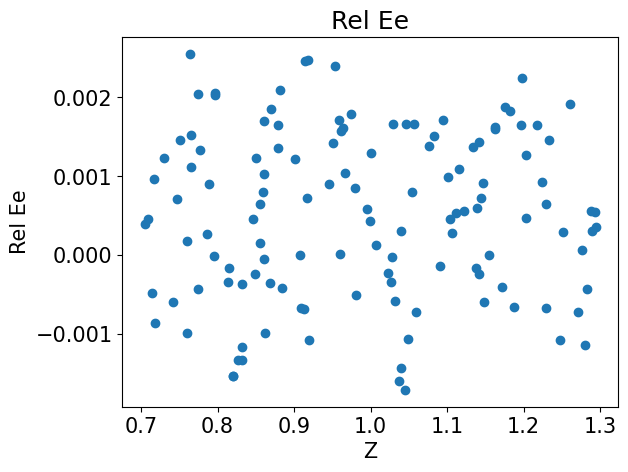

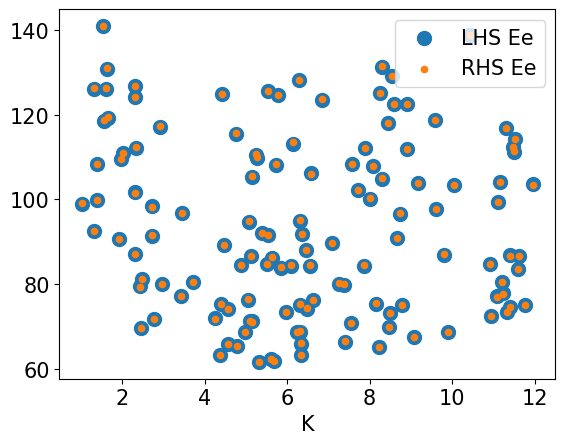

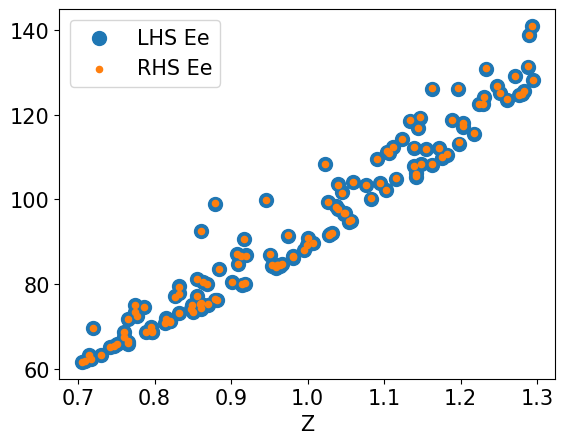

#=================================================================
episode = 17000, loss [log10] = -5.878658294677734
#=================================================================
episode = 18000, loss [log10] = -5.933340549468994
#=================================================================
episode = 19000, loss [log10] = -5.670571804046631


In [ ]:
# Keep results for plotting
train_loss = []

num_episodes = 20001
n_data_per_epi = 128
z_lb = 0.7
z_ub = 1.3
k_lb = 0.9
k_ub = 12.0


for ep in range(num_episodes):
    # generate training data
    X = get_training_data(z_lb, z_ub, k_lb, k_ub, n_data_per_epi)

    # compute loss and gradients
    loss, grads = grad(X, nn)
    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
       
        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 1], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

## Simulating the model from the policy
Given a policy function, we can simulate the model forward.
Say we start out with a state $\mathbf{X}_t=[z_t, K_t]$.  
We can use the neural network to obtain $K_{t+1} = Y_t \cdot \mathcal{N}(\mathbf{X}_t)$.  
Then, we can draw a random innovation $\epsilon_t\sim N(0, 1)$ using a pseudo-random number generator and obtain $Z_{t+1}=\rho Z_t + \sigma \epsilon_t$.  
Now we have $\mathbf{X}_{t+1}=[Z_{t+1}, K_{t+1}]$.  
We can repeat the same procedure to obtain $\mathbf{X}_{t+2}$ and so on and so forth.  
Next, we will implement a function that takes a batch of states, a batch of innovations, and the neural network and then simulates the states one period forward based on  the policy encoded by the neural network.  
Afterward, we will write a second function to simulate longer sequences.

In [30]:
@tf.function
def simulate_single_step(X_t, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation
    
    n_data = X_t.shape[0] # number of states is on the axis 0
    dim_state = X_t.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X_t[:, 0 : 1]
    K_t = X_t[:, 1 : 2]
    
    # compute output today
    Y_t = Z_t * K_t ** alpha
    
    # use the neural network to predict the savings rate
    s_t = nn(X_t)
    
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t
    
    # get tfp in the next period
    Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + sigma_tfp * eps_tplus1)    
    
    # construct the next step
    X_tplus1 = tf.concat([Z_tplus1, K_tplus1],axis = 1)
    
    return X_tplus1

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1
    
    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables
    
    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks), dtype = tf.float32)
    
    # set starting state
    X_simulation[0, :, :] = X_start
    
    X_old = X_start
    
    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, tf.newaxis] # newaxis makes sure the shape is n_tracks x 1
        
        X_new = simulate_single_step(X_old, eps_use, nn)
        
        X_simulation[t, :, :] = X_new
        
        X_old = X_new
        
    return X_simulation

In [31]:
# let's pick a starting state
X_start = np.array([[0.5 * (z_ub + z_lb), 0.5 * (k_ub + k_lb)]], dtype = np.float32)

# and simulate it some periods forward using the neural network
num_periods = 200 
X_simulation = sim_periods(X_start, nn, num_periods)

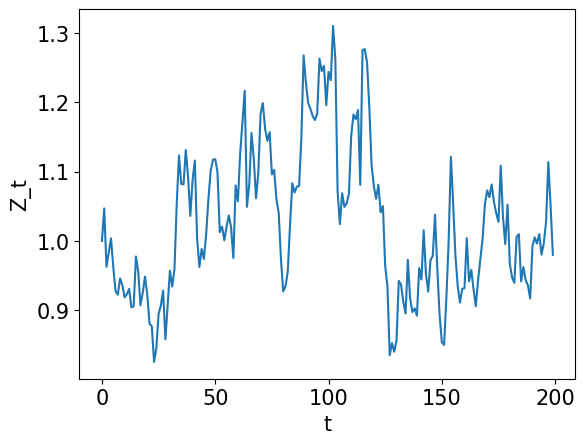

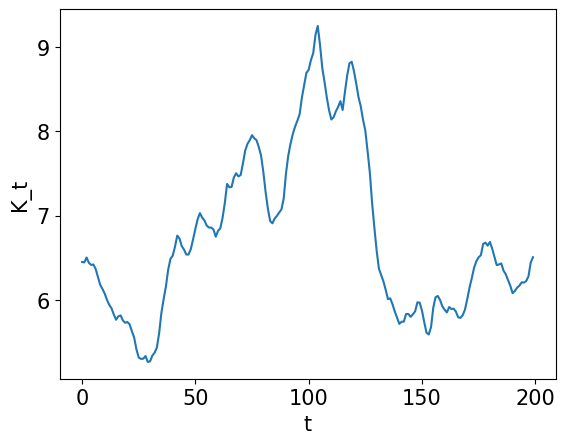

In [32]:
plt.plot(X_simulation[:, 0, 0])
plt.xlabel("t")
plt.ylabel("Z_t")
plt.show()

plt.plot(X_simulation[:, 0, 1])
plt.xlabel("t")
plt.ylabel("K_t")
plt.show()

Like often in macro, the two variables seem to be moving together, so let's try to get a sense of the **ergodic distribution** of the state space.

In [34]:
num_periods = 10000

# we simulate more periods
X_simulation = sim_periods(X_start, nn, num_periods)

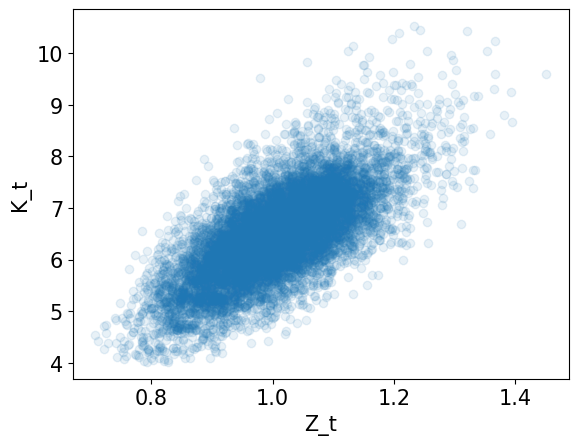

In [35]:
# we make a scatter plot for the two state-variables
plt.scatter(X_simulation[:, 0, 0], X_simulation[:, 0, 1], alpha = 0.1)
plt.xlabel("Z_t")
plt.ylabel("K_t")
plt.show()

As we can see the model essentially lives on a cloud around the diagonal.  
The model never reaches states with extremely low productivity and extremely high capital or states with extremely high  productivity and extremely low capital.  
This means all the effort we spent training the neural network in these areas (top left and bottom right) was essentially in vain.  
With more than two variables, this issues becomes exponentially more extreme (see [Maliar et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0165188910002186) for more information on this topic).  
Moreover, we may not even know where the cloud will be, since it depends on the very policy we want to solve for!  
Hence, it would be very good if we could simultaneously learn the policy on the cloud of interest while also moving the cloud as we update the policies.  
[Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575) address this issue by iterating between **simulating new states** from the neural network policy and then **training the neural network** on those simulated states. This is what we will do next.

## Iterating between training an simulation
What changes compared to our previous approach? Only how we sample the states! 

Instead of drawing exogenously from a given interval, we simulate the model using  the policy encoded in the neural network. 
Since neural networks can be very efficiently executed on batches, and to increase independence of the data, we simulate more than one track in parallel, but each for a shorter period of times. For example, we can get 1000  simulated states by either simulating one track for 1000 periods of 100 tracks for 10 periods, the latter will be much faster.  

In [44]:
def get_training_data_simulation(X_start, nn, n_periods):
    n_tracks = X_start.shape[0]
    n_dim = X_start.shape[1]
    
    # we simulate the model
    X_simulation = sim_periods(X_start, nn, n_periods)
    
    # we read out the last state (so that we can use it as starting poit for the next simulation)
    X_end = np.float32(X_simulation[-1, :, :])
    
    # we reshape the data into (n_tracks * n_periods) x 2 array 
    X_training = np.float32(np.reshape(X_simulation, (n_tracks * n_periods, n_dim)))
    
    return X_training, X_end 

In [69]:
# let's try
# let's get a new neural network
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation='sigmoid')
])


n_tracks = 50
n_periods = 3
print("n_tracks = ", n_tracks)
print("n_periods = ", n_periods)

# start from a random state
X_start = get_training_data(z_lb, z_ub, k_lb, k_ub, n_tracks)
print("X_start.shape = ", X_start.shape)

print("With every simulation we get", n_tracks * n_periods, "new states")

X_training, X_end = get_training_data_simulation(X_start, nn, n_periods)
print("X_training.shape = ", X_training.shape)
print("X_end.shape = ", X_end.shape)

learning_rate = 0.0001
print("learning_rate = ", learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print(compute_cost(X_start, nn)[0])

n_tracks =  50
n_periods =  3
X_start.shape =  (50, 2)
With every simulation we get 150 new states
X_training.shape =  (150, 2)
X_end.shape =  (50, 2)
learning_rate =  0.0001
tf.Tensor(0.0014475349, shape=(), dtype=float32)


The only thing that changes in the training loop is how we sample the data.

In [1]:
# Keep results for plotting
train_loss = []

num_episodes = 20001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()
        
        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0], X[:, 1])
        plt.xlabel("Z")
        plt.ylabel("K")
        plt.show()
        plt.close()
        
        
        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
       
        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 1], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

NameError: name 'X_end' is not defined

**Final but important remark on simulation based methods:** Without a question, simulation based methods offer a huge advantage, exponentially so in high dimensions. However, they also introduce some fragility into the learning process, since the distribution of the training data changes when the policy changes. On the one hand, this is exactly what we want, but on the other hand, it can make training unstable when moving too quikly to unseen data. Hence some parameters may have to be optimized more carefully, **especially the learning rate**, so that the data distribution is not changing to quickly. Depending on the model, we may also need to take care of the fact that in the beginning of training the neural network policies are random and may hence predict infeasible states (like negative aggregate capital), which make useful learning impossible. 
[Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575) address some of these points in the appendices and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market-clearing neural network architectures, as well as a procedure to introduce multiple assets, which stabilized training.